# ANN Course Project by ANKIT SHARMA (24/AFI/05)

### Import the required libraries

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
import pickle
import pandas
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

### Load Dataset

In [ ]:
pickle_file = "/data/world_events_dataset_from_1980.pkl"

try:
    # Load the DataFrame
    with open(pickle_file, "rb") as file:
        data = pickle.load(file)

        # Check if it's a DataFrame
        if isinstance(data, pd.DataFrame):
            # Get the last 20 rows
            last_20_rows = data.tail(20)

            # Display the DataFrame in a natural table format
            from IPython.display import display
            display(last_20_rows)
        else:
            print(f"Unexpected data type: {type(data)}. Please check the file content.")
except FileNotFoundError:
    print("The specified pickle file does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

,wiki_name,date,country,Category,High-Category,ref_num,avg_num_views,embedding
16746,2020 Vermont gubernatorial election,2020-11-03,Vermont,Election,SocietalEvent,41,271.812098,"[-0.3710651, 0.64300466, 0.57575923, 0.3711877..."
16747,2020 United States presidential election in Vi...,2020-11-03,Virginia,Election,SocietalEvent,66,347.890212,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16748,2020 United States presidential election in th...,2020-11-03,"Washington,_D.C.",Election,SocietalEvent,30,152.291391,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16749,2020 United States presidential election in Wa...,2020-11-03,Washington_(state),Election,SocietalEvent,54,207.650794,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16750,2020 West Virginia gubernatorial election,2020-11-03,West Virginia,Election,SocietalEvent,66,258.052229,"[0.05111569, -0.1453084, -0.05666516, -0.33789..."
16751,2020 United States presidential election in We...,2020-11-03,West_Virginia,Election,SocietalEvent,44,187.272487,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16752,2020 United States presidential election in Wi...,2020-11-03,Wisconsin,Election,SocietalEvent,245,752.906085,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16753,2020 United States presidential election in Wy...,2020-11-03,Wyoming,Election,SocietalEvent,33,158.411376,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16754,2020 Myanmar general election,2020-11-08,Myanmar,Election,SocietalEvent,0,464.019481,"[0.32944024, -0.096266605, 0.51983714, -0.0546..."
16755,2020 Masters Tournament,2020-11-12,United States of America,GolfTournament,SportsEvent,40,865.785174,"[-0.33693168, 1.6073282, -0.6598441, -0.238583..."


In [ ]:
df = pd.read_csv('data/train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


### Missing Values Imputation
There are no missing values in the dataset.

In [ ]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### Data Preprocessing
For simplicity, we only consider the sales of 'item' - 1 from 'store' - 1. The dataset is split into train and test sets, where the train set contains sales record from January 2013 to September 2017 and the test set contains sales records of the last three month of 2017.


In [ ]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [ ]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,21,2017,10,1,6
1,2017-10-02,1,1,12,2017,10,2,7
2,2017-10-03,1,1,18,2017,10,3,1
3,2017-10-04,1,1,15,2017,10,4,2
4,2017-10-05,1,1,20,2017,10,5,3


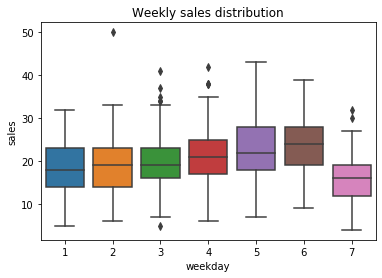

In [ ]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

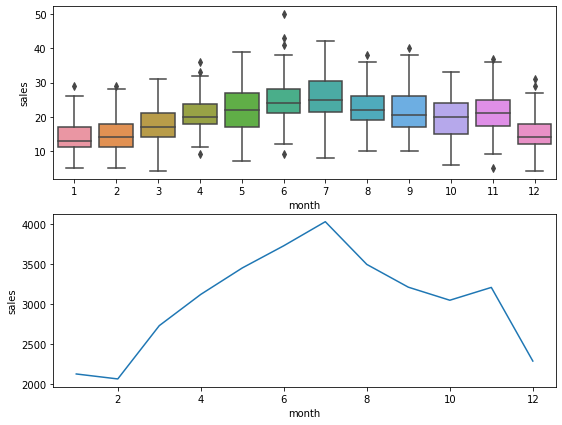

In [ ]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

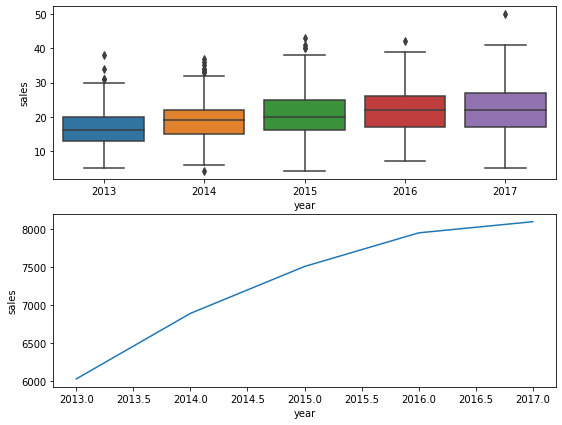

In [ ]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

The aggregate number of sales has increased from approximately 6000 in 2013 to slightly over 8000 in 2017.

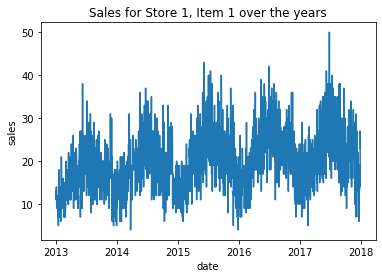

In [ ]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

<b>Inference:</b> There is a seasonal pattern in the number of sales of 'item' - 1 at 'store' - 1. As also infered in the plot for sales vs. month above, we can see an increase in the sales in the first half of the year, peaking in July, and then a gradual decrease till December. This pattern is repeated each year, 2013 onwards.

### Seasonal Sales



It is a naive method that takes the seasonal patterns into account by looking at what happened same time last year. For example, if we want to predict the sales during December 2017, the seasonal naive method will assume the same number of sales for December 2017 as was in December 2016. Fortunately, we have at least one-year of sales data, this method might make no sense otherwise. <br>

In the code below, one year is subtracted from the dates in the test data, and one day is added to the resulting difference, after which they are looked up in the training data to return the sales from those respective dates. So keeping the seasonality in mind, we now have our naive forecasts based on the number of sales from a year ago.

In [ ]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]')
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales']

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,date,store,item,year,month,day,weekday,seasonal_naive_sales
0,2017-10-01,1,1,2017,10,1,6,25
1,2017-10-02,1,1,2017,10,2,7,26
2,2017-10-03,1,1,2017,10,3,1,20
3,2017-10-04,1,1,2017,10,4,2,28
4,2017-10-05,1,1,2017,10,5,3,17


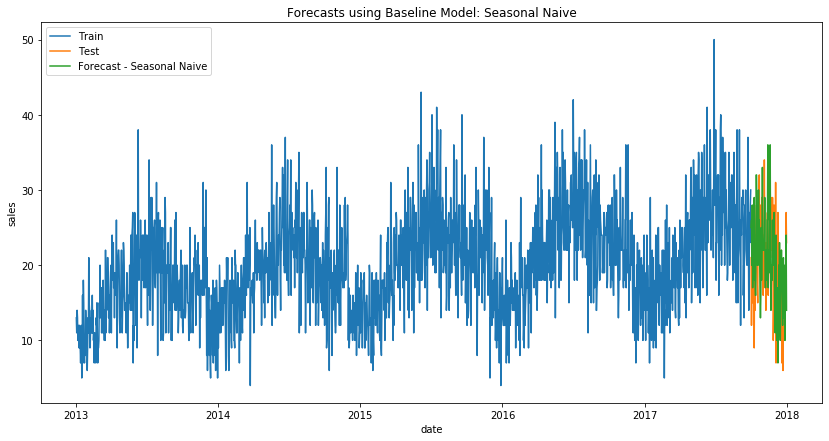

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

<b> Inference: </b> To the naked eye, the forecasts seem alright the decreasing trend is clearly captured by our naive method. However, we will formally quantify the performance using forecast accuracy metrics.

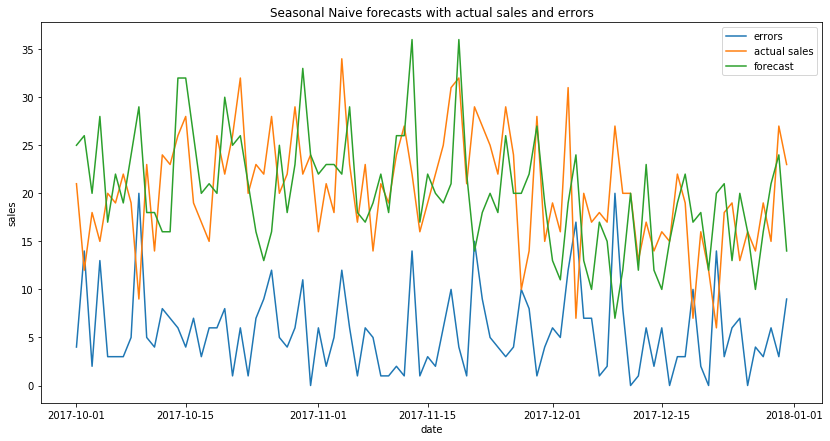

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1861,1857,4,5.630435,7.130766,27.834498


In [ ]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))


plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

The overall error is not as bad with <b>MAPE of 27.8%</b>.

<Figure size 432x288 with 0 Axes>

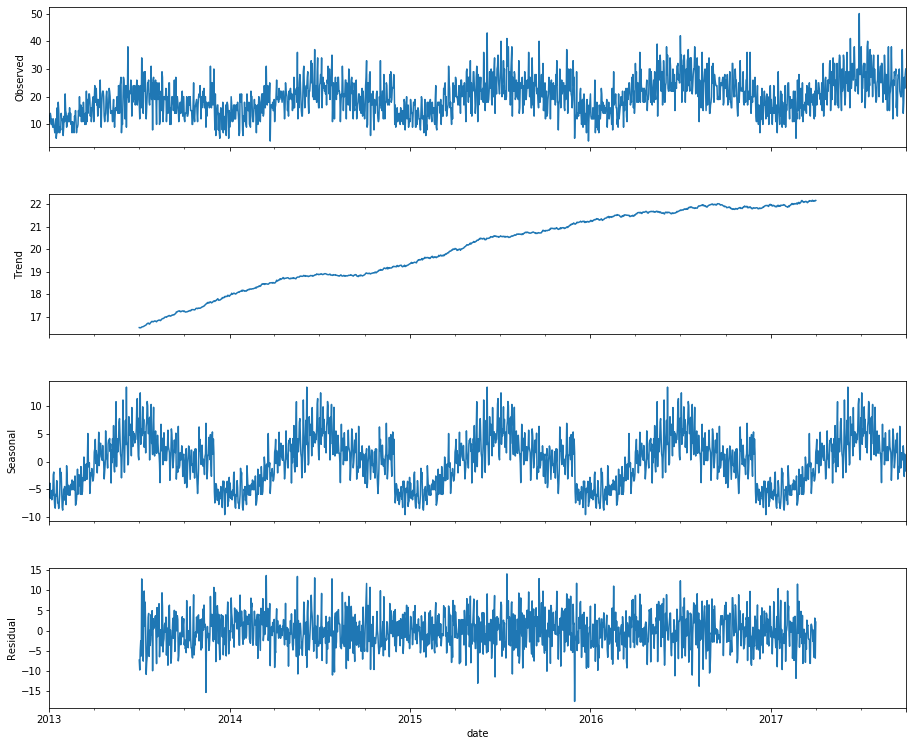

In [ ]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', freq=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

### Autoregressive Integrated Moving Average - ARIMA Model

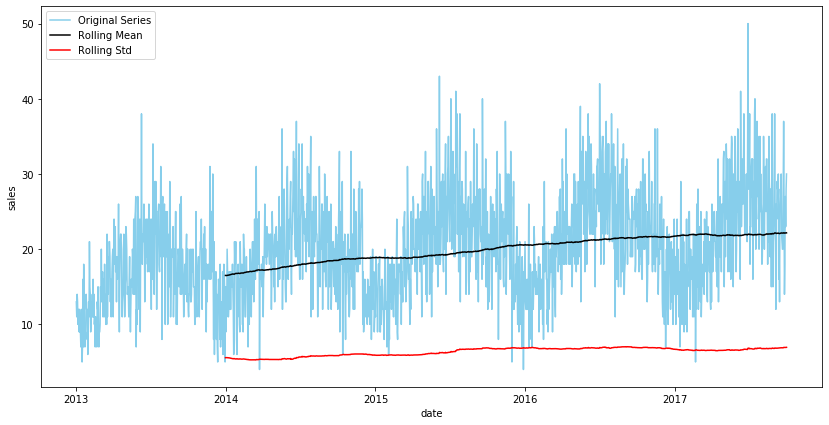

Test statistic = -2.937
P-value = 0.041
Critical values :
	1%: -3.434179908502461 - The data is not stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


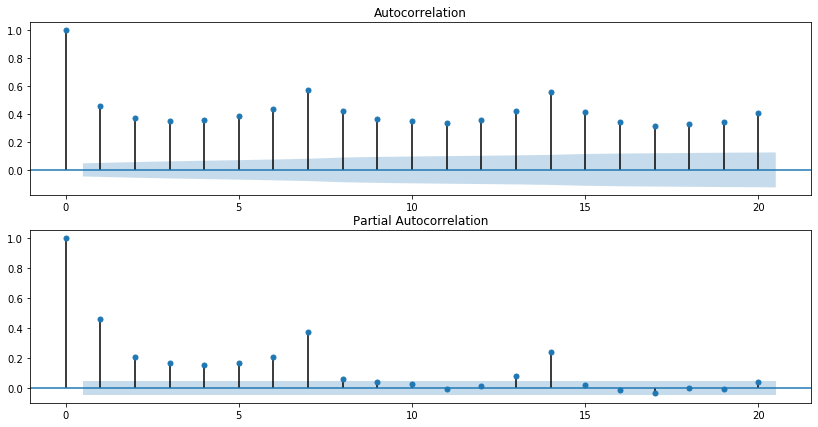

In [ ]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()

    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")

    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)

test_stationarity(arima_df.sales)

Looking at the results from our test, we can conclude that the series is not stationary. Therefore, in order to make the series stationary we apply <b> Differencing </b>

#### Differencing

<b>Differencing:</b> Seasonal or cyclical patterns can be removed by substracting periodical values. If the data is 12-month seasonal, substracting the series with a 12-lag difference series will give a “flatter” series. Since we have aggregated the data to each day-level, we will shift by 1.

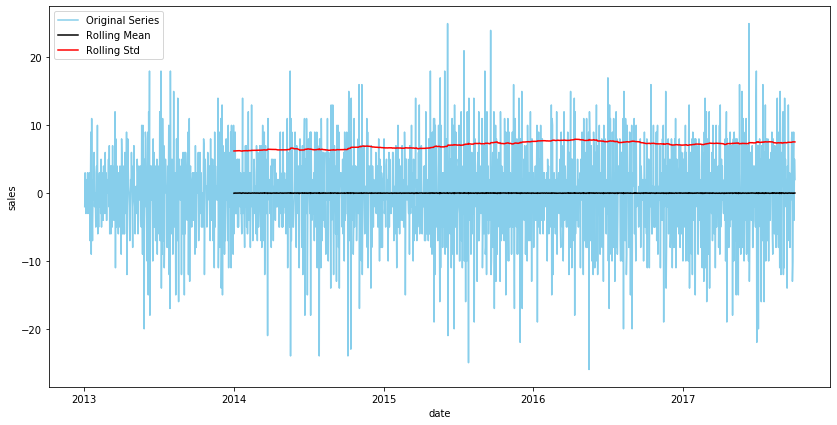

Test statistic = -12.326
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


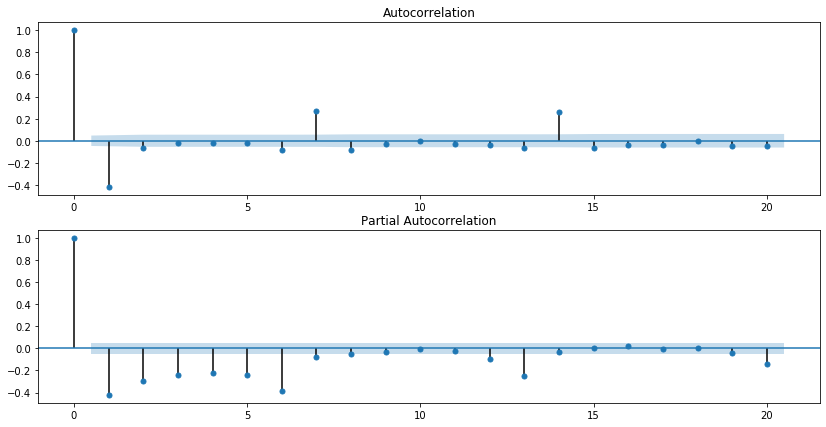

In [ ]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

After applying Differencing to the series, we can see from the above results that the series is now stationary, i.e. mean and variance are constant over time, and from ADF we can verify that the test-statistic is lesser than the critical value, hence we can reject the null hypothesis and conclude that the series is staionary.

In [ ]:
arima_model61 = ARIMA(arima_df.sales, (6,1,1)).fit(disp=False)
print(arima_model61.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1733
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5313.030
Method:                       css-mle   S.D. of innovations              5.188
Date:                Sun, 22 Dec 2019   AIC                          10642.059
Time:                        13:36:56   BIC                          10685.720
Sample:                    01-02-2013   HQIC                         10658.207
                         - 09-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0071      0.026      0.273      0.785      -0.044       0.058
ar.L1.D.sales    -0.8147      0.022    -36.813      0.000      -0.858      -0.771
ar.L2.D.sales    -0.7558      0.027    -

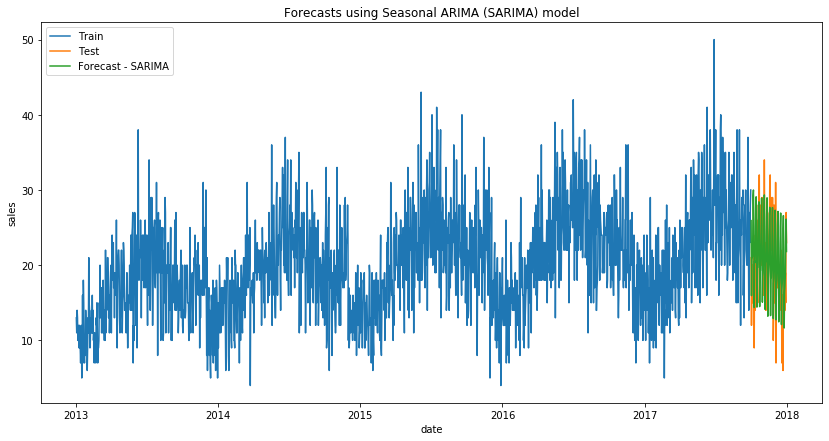

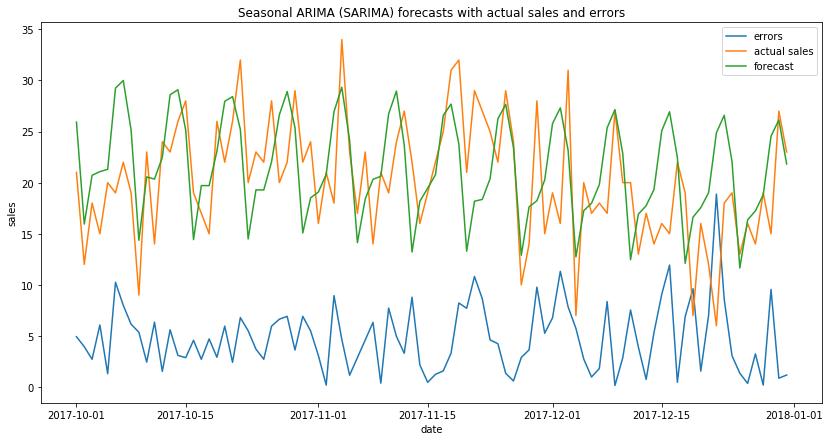

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,1861,1973.197446,-112.197446,4.799933,5.839147,23.728846


In [ ]:
# eval
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_sarima

<b>Inference: </b> The SARIMA model with <b>MAPE of 23.7%</b> performed better than our baseline model, but couldn't better the Holt-Winter's Triple Exponential Smoothing method.

### Linear Regression


In [ ]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,2
1822,2017-12-28,1,1,19,2017,12,28,3
1823,2017-12-29,1,1,15,2017,12,29,4
1824,2017-12-30,1,1,27,2017,12,30,5


#### Step 1: Feature Engineering

In [ ]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)

# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-09-30']
reg_test_df = reg_df.loc['2017-10-01':]

#### Step 2: Feature Selection and Model Building

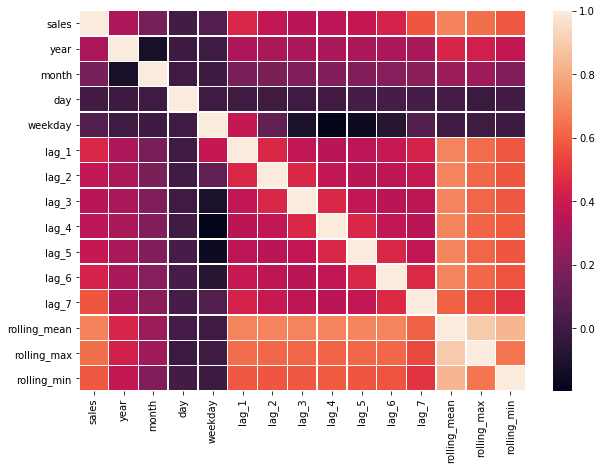

In [ ]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [ ]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
11  rolling_mean  1577.946956
12   rolling_max  1170.464035
13   rolling_min   888.451268
10         lag_7   860.565955
4          lag_1   449.743115


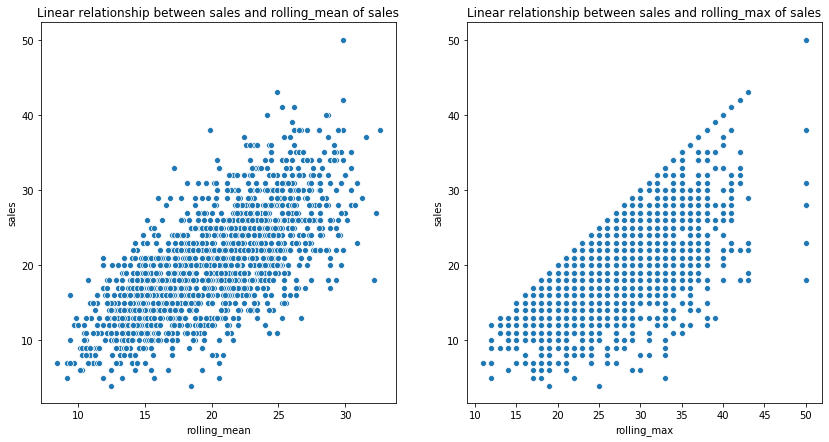

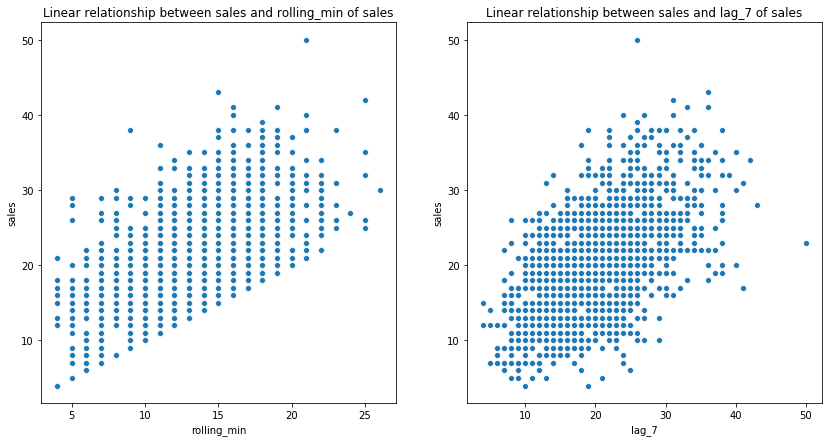

In [ ]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_mean, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_train_df.rolling_max, reg_train_df.sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_min, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_train_df.lag_7, reg_train_df.sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [ ]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

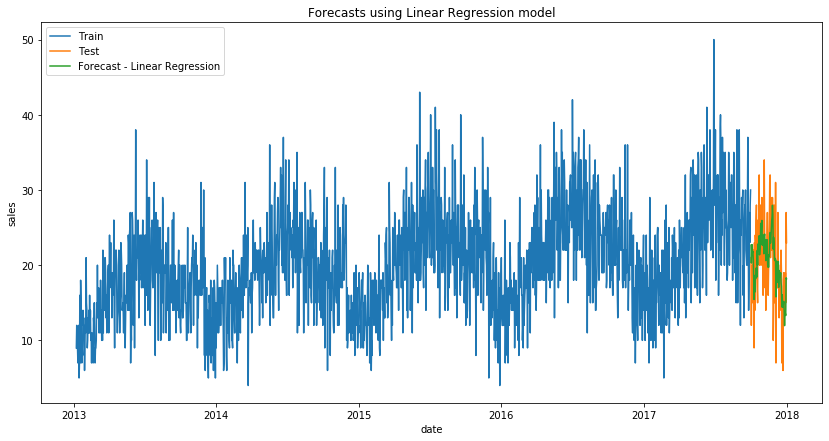

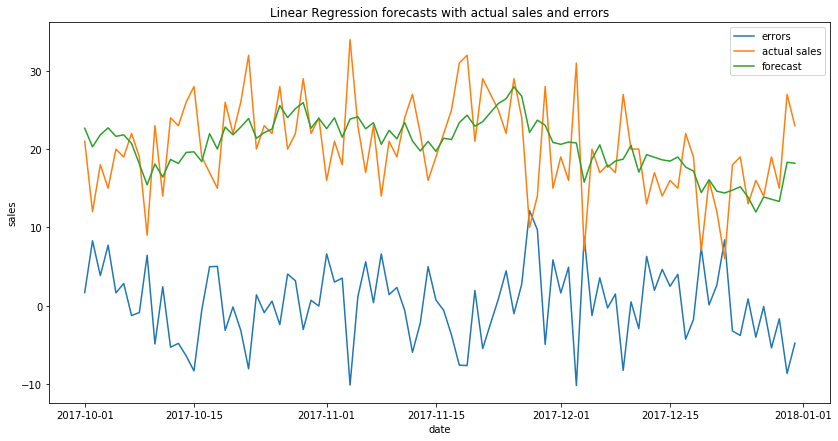

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1861,1882.074831,21.074831,3.858646,4.786183,19.075519


In [ ]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_lr

<b> Inference: </b> The Linear regression model captures the upwards as well as the downwards movement in the sales data. Its performance, <b> MAPE 19.07% </b>, is best.

### Conclusion

We considered different time-series models as well as a regression model for time series forecasting. From our results we saw that the linear regression model outperformed the other time-series models. Therefore, for this dataset we could use a regression model, rather than a time-series model to forecast sales. One of the main assumptions of regression models is that the patterns in the historical data will be repeated in the future, and since our data was highly seasonal and had a linear trend, it made sense why the linear regression model out-performed the other models.